# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [21]:
from relaxed.analysis import setup, get_quantiles, get_am, get_an_from_am, get_lam, get_ma, get_gradient, \
get_fractional_tdyn, get_savgol_grads, get_tt_indices, add_box_indices, vol_jacknife_err
from relaxed.models import training_suite

# Data

In [22]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
cat = hcat.cat
xoff = cat['xoff']
cvir = cat['cvir']
eta = cat['eta']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')
a2 = get_an_from_am(am, mass_bins)

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape, mass_bins.shape, a2.shape, cvir.shape, xoff.shape, eta.shape)

(30000, 98) (98,) (30000,) (30000,) (30000,) (30000,)


In [23]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [24]:
 # remove nan's from lam along the way, like ~1k hadd_box_indiceses.
lam, keep = get_lam(am)
cat, am, cvir, xoff, eta = cat[keep], am[keep], cvir[keep], xoff[keep], eta[keep]
print(len(cat), am.shape, cvir.shape, xoff.shape, eta.shape)

28366 (28366, 98) (28366,) (28366,) (28366,)


In [25]:
# train/test split.
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.5)

cat_train, am_train, cvir_train, xoff_train, eta_train = (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                          xoff[train_idx], eta[train_idx])
cat_test, am_test, cvir_test, xoff_test, eta_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                          xoff[test_idx], eta[test_idx])

print(cvir_train.shape, cvir_test.shape)

(14183,) (14183,)


# Train

In [26]:
# all cvir models are specified in data.
data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': -1}},
    'linear_trans': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': False, 'use_logs': False}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}
    }
}
cvir_models = training_suite(data)

In [27]:
# eta models
data = {
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}}
}
eta_models = training_suite(data)

In [28]:
# all xoff models
data = {
    'cam_1/2': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}}
}
xoff_models = training_suite(data)

# Plots

## Combined histogram of residuals

In [104]:
def summary_statistics(model, _x_test, _y_test, box_keep = None):
    if box_keep is None:
        box_keep = np.ones(_x_test.shape[0]).astype(bool)
    
    x_test = _x_test[box_keep]
    y_test = _y_test[box_keep]
    
    y_pred = model.predict(x_test)
    x = (y_pred - y_test) / np.std(y_test) # normalize

    return {'mu': np.mean(x), 
            'med': np.median(x),
            'sigma_ratio': np.std(y_pred) / np.std(y_test), 
            'corr': scipy.stats.spearmanr(y_pred, y_test)[0],
           }


# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", 
                       xrange=(-3, 3), figsize=(20, 10), legend_size=20, log=False, 
                       calc_errs = False, cat_test=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = (y_pred - y_test) / np.std(y_test) # normalize
        summ = summary_statistics(model, x_test, y_test)
          
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        label1 = f"{label}, $(\\rho, \\mu, \\mu', \\sigma_p / \\sigma_t)="
        label2 = f"({summ['corr']:.2f}, {summ['mu']:.2f}, {summ['med']:.2f}, {summ['sigma_ratio']:.2f})$"

        # calculate uncertainties
        if calc_errs:
            assert cat_test is not None
            err = vol_jacknife_err(summary_statistics, cat_test, model, x_test, y_test, mode='dict')
            label2 = (f"({summ['corr']:.2f} \\pm {err['corr']:.2f}, {summ['mu']:.2f} \\pm {err['mu']:.2f},"
                     f"{summ['med']:.2f} \\pm {err['med']:.2f}, {summ['sigma_ratio']:.2f} \\pm {err['sigma_ratio']:.2f})$")
        label = label1 + label2

        draw_histogram(ax, x, vline=summ['mu'], label=label, color=color, bins=bins, density=False)
        
    ax.axvline(0, color='k', ls='--')
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / \\sigma({v_test})$", size=28)
    
    if log: 
        ax.set_yscale('log')
        
        
    # format legend
    ax.legend(loc='lower left', prop={'size':legend_size}, bbox_to_anchor=(0., 1.02, 1., .202), 
              ncol=1,  borderaxespad=0.)

### Cvir

In [99]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'linear_trans': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'orange'),}

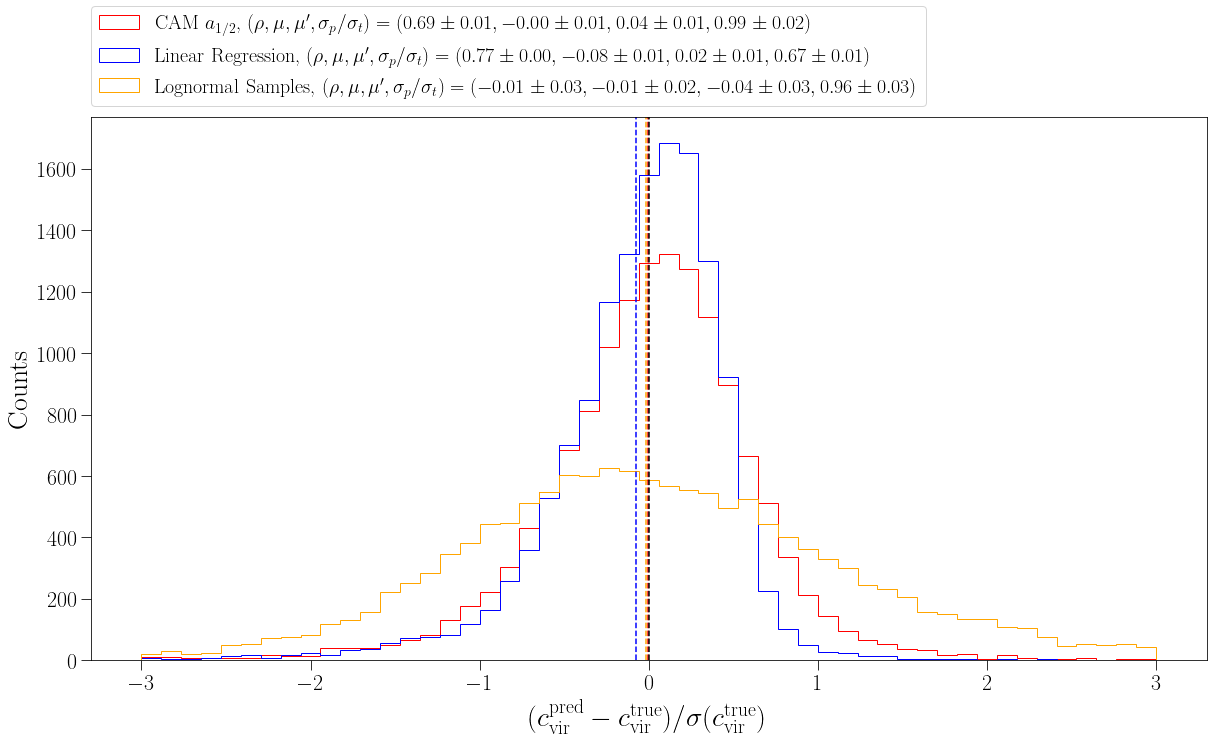

In [100]:
combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-3, 3), 
                   calc_errs=True, cat_test=cat_test)

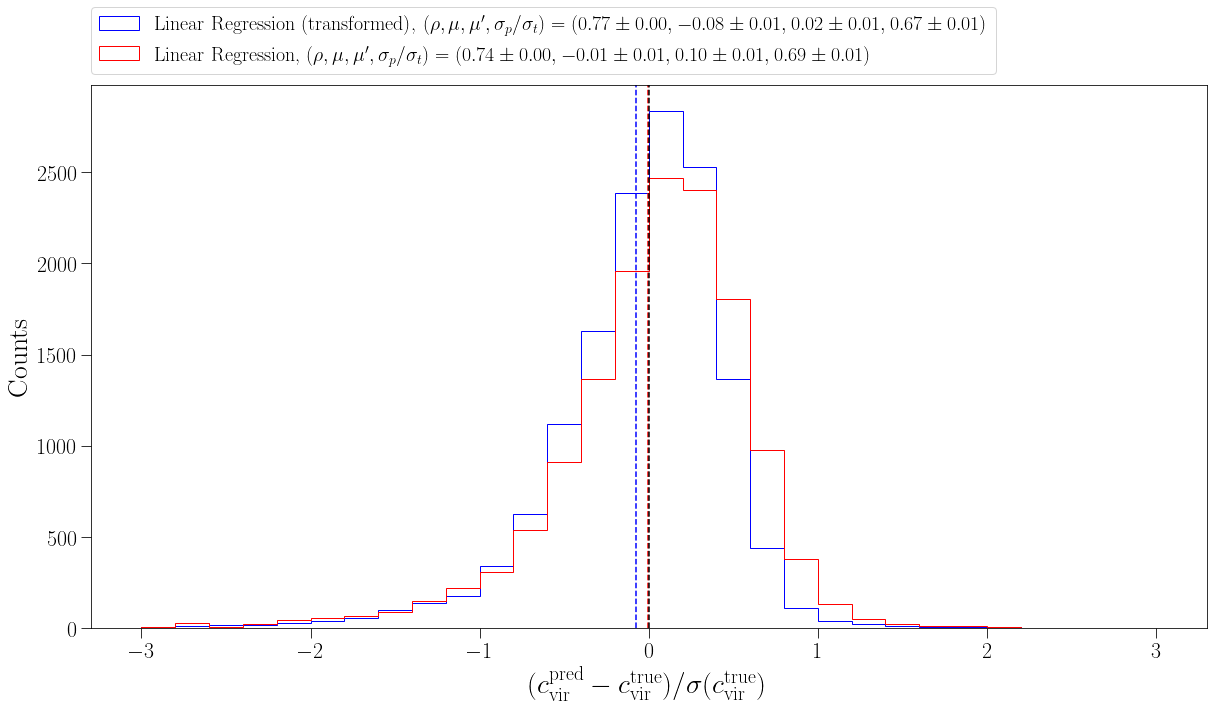

In [101]:
test_data = {'linear_trans': (am_test, "\\rm Linear Regression (transformed)", 'b'),
            'linear': (am_test, "\\rm Linear Regression", 'r'),}
combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=30, xrange=(-3, 3), 
                  calc_errs=True, cat_test=cat_test)
# we note that the quantile transformer is actually doing work in finding an optimal subspace in which to do the regression.

### Xoff

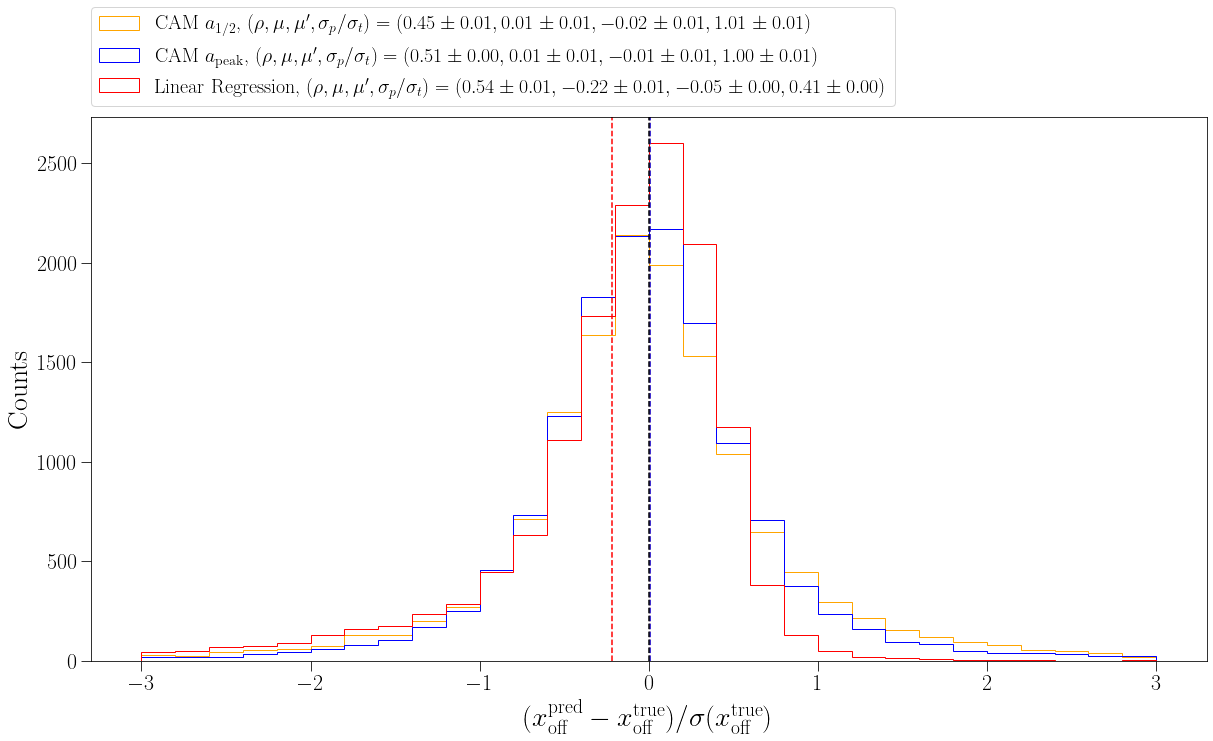

In [102]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'orange'),
            'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'b'),
            'linear': (am_test, "\\rm Linear Regression", 'r'),}
combined_histogram(test_data, xoff_test, xoff_models, latex_var=r'x_{\rm off}', n_bins=30, xrange=(-3, 3), 
                  calc_errs=True, cat_test=cat_test)

### eta

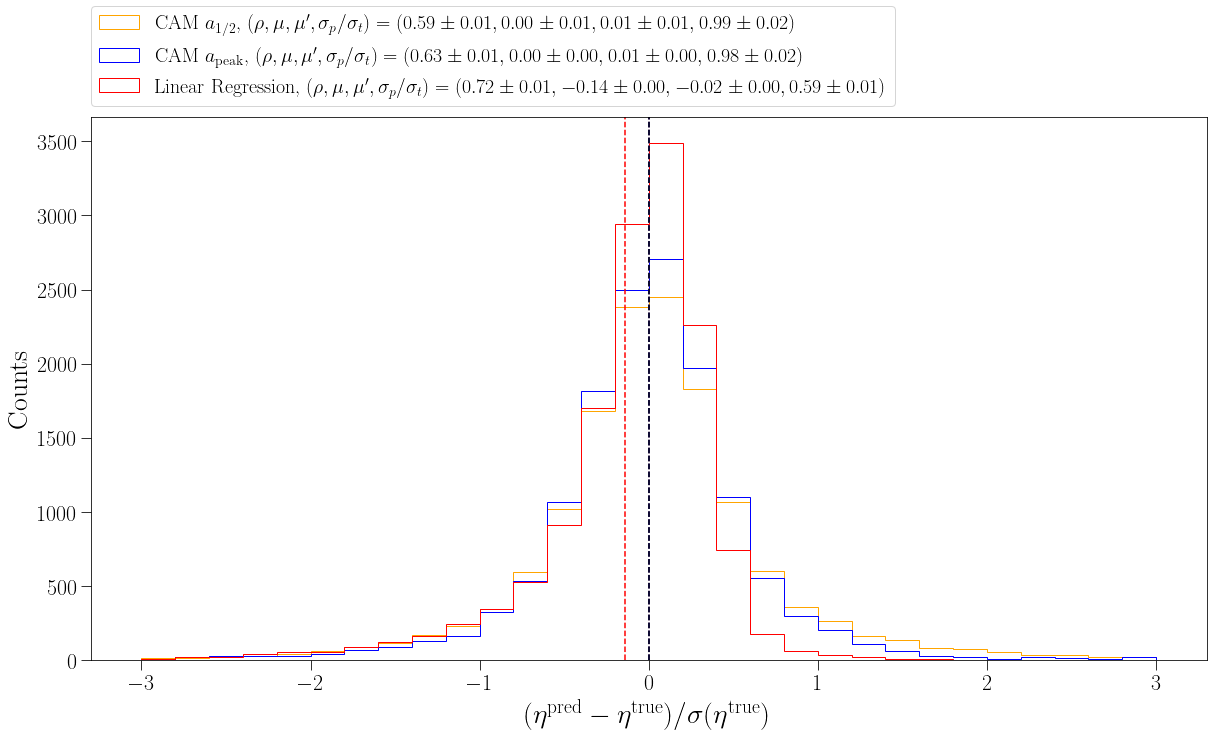

In [106]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'orange'),
            'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'b'),
            'linear': (am_test, "\\rm Linear Regression", 'r'),}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=30, xrange=(-3, 3), 
                   calc_errs=True, cat_test=cat_test)

## Scatter plots of residuals

In [112]:
def scatter_plots(test_data: dict, y_test, trained_models, a_peak_test, alpha=0.5, latex_var=""): 
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = y_pred / y_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        ax1.scatter(y_test, x, alpha=alpha, color=color, label=label)
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        
        
        ax2.scatter(y_pred, x, alpha=alpha, color=color, label=label)
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        ax3.scatter(a_peak_test, x, alpha=alpha, color=color, label=label)
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # add median line
        print(f'median {name}: ', np.median(x))
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

median cam_1/2:  1.0244255306802676
median linear_trans:  1.013910922269941
median lognormal:  0.9840374255567135


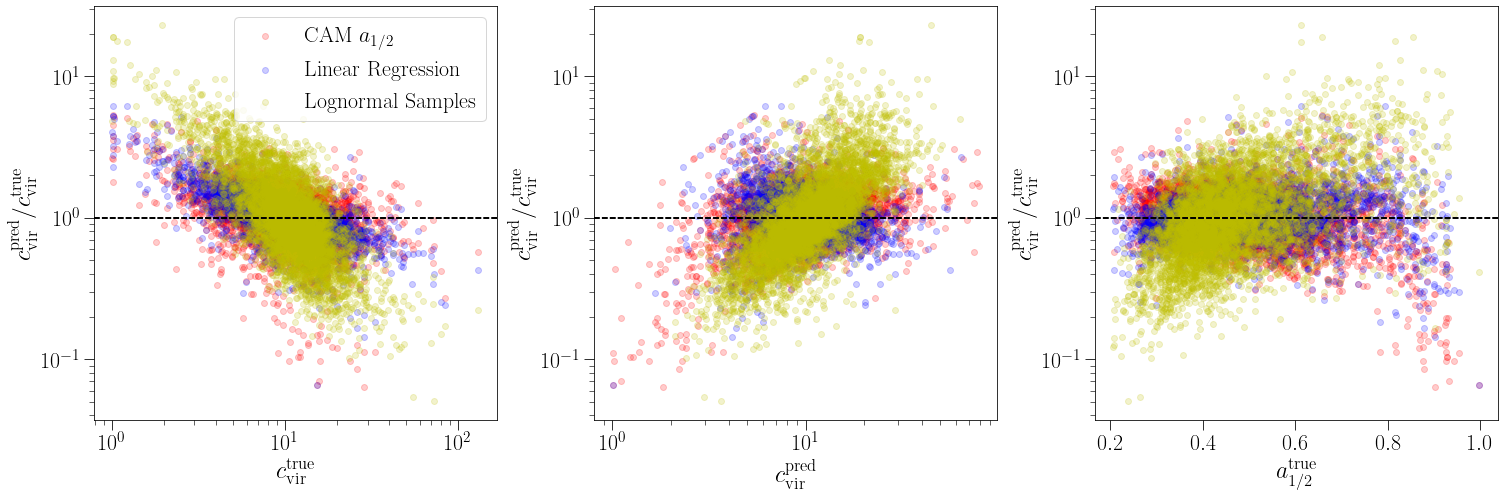

In [115]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'linear_trans': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'y'),}
a_2_test = get_an_from_am(am_test, mass_bins)
scatter_plots(test_data, cvir_test, cvir_models, a_2_test, alpha=0.2, latex_var=r'c_{\rm vir}')

## Median bin statistic

In [116]:
def make_scatter_binning(ax, x, y, n_xbins=15, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    ax.errorbar(
        xmeds,
        ymeds,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

In [129]:
def median_bin_statistic(test_data, y_test, trained_models, a_peak_test, log_scale=True, latex_var=""):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = y_pred / y_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        make_scatter_binning(ax1, y_test, x, color=color, label=label)
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        

        make_scatter_binning(ax2, y_pred, x, color=color, label=label)
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        make_scatter_binning(ax3, a_peak_test, x, color=color, label=label)
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # visual guides.
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        if log_scale: 
            # set scales.
            ax1.set_xscale('log')
            ax2.set_xscale('log')

            ax1.set_yscale('log')
            ax2.set_yscale('log')
            ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

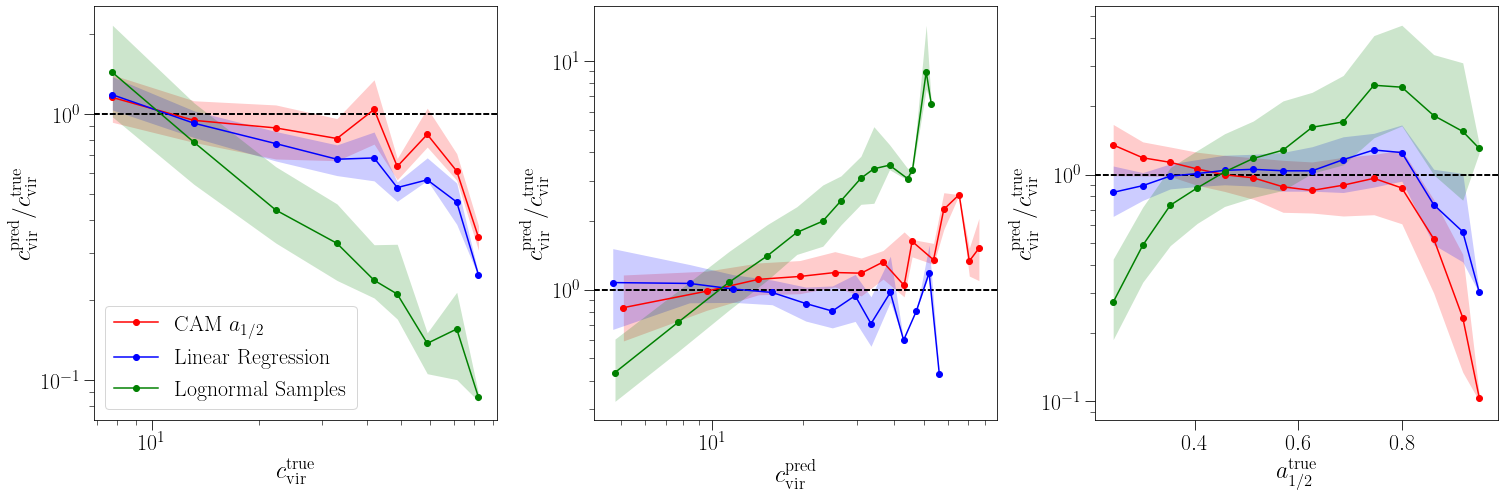

In [130]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'linear_trans': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'g'),}
a_2_test = get_an_from_am(am_test, mass_bins)
median_bin_statistic(test_data, cvir_test, cvir_models, a_2_test, latex_var=r'c_{\rm vir}')

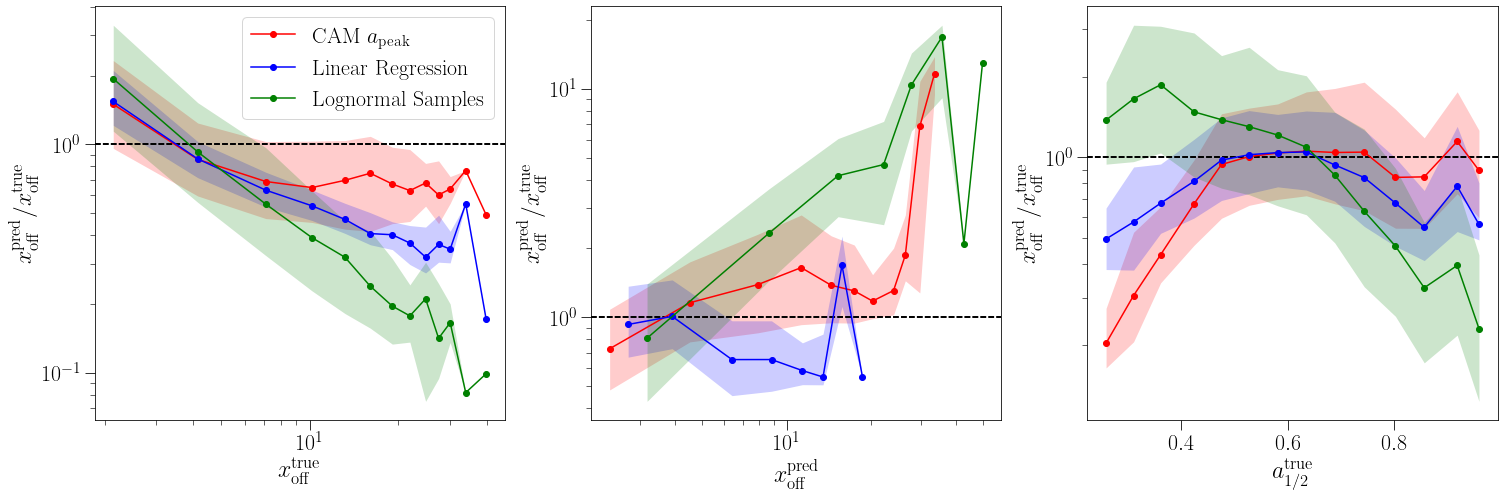

In [141]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{\\rm peak}$", 'r'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'g'),}
a_peak_test = get_an_from_am(am_test, mass_bins, mrange=(0.738, 0.740))
median_bin_statistic(test_data, xoff_test, xoff_models, a_peak_test, latex_var=r'x_{\rm off}')

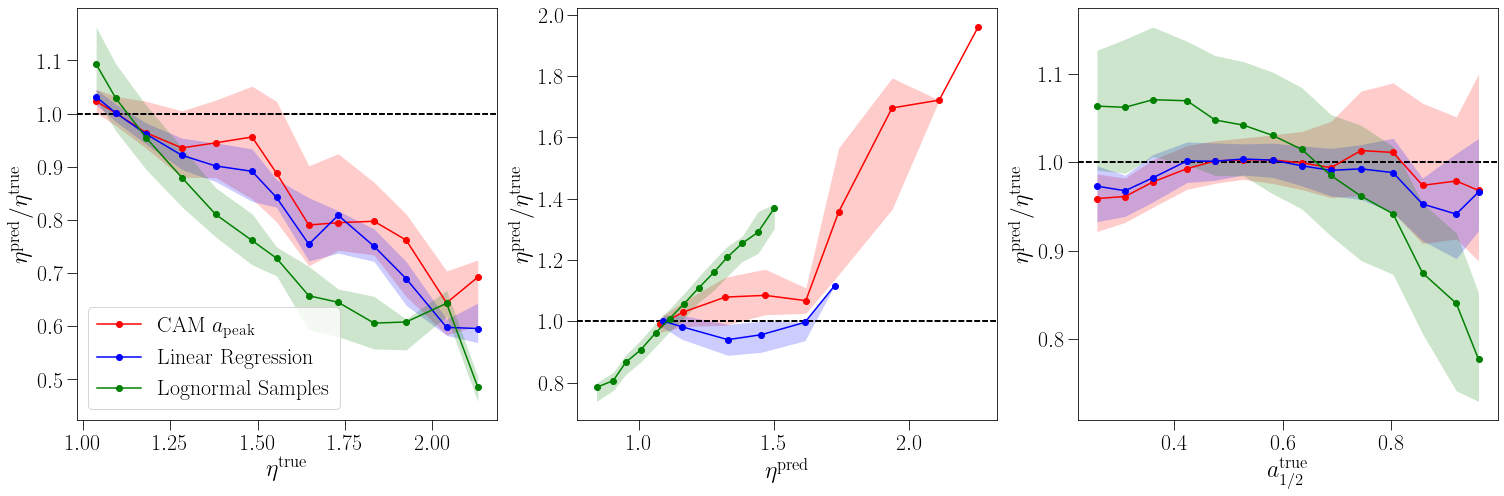

In [142]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{\\rm peak}$", 'r'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'g'),}
a_peak_test = get_an_from_am(am_test, mass_bins, mrange=(0.738, 0.740))
median_bin_statistic(test_data, eta_test, eta_models, a_peak_test, latex_var=r'\eta', log_scale=False)